# 🛰️ RSI-CB128 — Classification d'Images Satellite avec CNN PyTorch
## Contrôle Continu Deep Learning

**Dataset** : RSI-CB128 (Remote Sensing Image Classification Benchmark)  
**Framework** : PyTorch  
**Auteur** : TSANGNING GRACE  
**Année** : M2 — 2025/2026

---


## 📦 1. Imports et Configuration

In [1]:
import os
import json
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from datetime import datetime
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# ── Reproductibilité ──
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

# ── Device ──
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"✅ Tous les imports réalisés avec succès!")
print(f"\n📊 Environnement PyTorch :")
print(f"  • Version PyTorch : {torch.__version__}")
print(f"  • Device         : {device}")
if torch.cuda.is_available():
    print(f"  • GPU            : {torch.cuda.get_device_name(0)}")
    print(f"  • Mémoire GPU    : {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print(f"  • GPU            : Non disponible (CPU uniquement)")


✅ Tous les imports réalisés avec succès!

📊 Environnement PyTorch :
  • Version PyTorch : 2.5.1+cu121
  • Device         : cuda
  • GPU            : NVIDIA GeForce RTX 4060 Laptop GPU
  • Mémoire GPU    : 8.6 GB


## ⚙️ 2. Paramètres

In [2]:
# ── Chemin vers le dataset ──
BASE_PATH = r"D:\M2 SEMESTRE1\NLP\CNN\archive\RSI-CB128"

# ── Hyperparamètres ──
IMG_SIZE   = 128
BATCH_SIZE = 32
EPOCHS     = 20
LR         = 0.001

# Répartition identique au notebook TensorFlow
TEST_SPLIT       = 0.10   # 10% test
VALIDATION_SPLIT = 0.20   # 20% val (sur train+val)

# Vérification du chemin
if os.path.exists(BASE_PATH):
    print(f"✅ Dataset trouvé à : {BASE_PATH}")
else:
    print(f"❌ ERREUR : Le chemin n'existe pas → {BASE_PATH}")

print(f"\n⚙️ Paramètres d'entraînement :")
print(f"  • Taille images  : {IMG_SIZE}×{IMG_SIZE}")
print(f"  • Batch size     : {BATCH_SIZE}")
print(f"  • Époques        : {EPOCHS}")
print(f"  • Learning rate  : {LR}")
print(f"  • Test split     : {TEST_SPLIT*100:.0f}%")
print(f"  • Val split      : {VALIDATION_SPLIT*100:.0f}%")
print(f"  • Device         : {device}")


✅ Dataset trouvé à : D:\M2 SEMESTRE1\NLP\CNN\archive\RSI-CB128

⚙️ Paramètres d'entraînement :
  • Taille images  : 128×128
  • Batch size     : 32
  • Époques        : 20
  • Learning rate  : 0.001
  • Test split     : 10%
  • Val split      : 20%
  • Device         : cuda


## 🗂️ 3. Exploration du Dataset

In [3]:
# Lister les catégories principales
categories = sorted([d for d in os.listdir(BASE_PATH)
                     if os.path.isdir(os.path.join(BASE_PATH, d))])

print(f"📁 Nombre de catégories principales : {len(categories)}\n")
for i, cat in enumerate(categories, 1):
    print(f"  {i}. {cat}")


📁 Nombre de catégories principales : 7

  1. construction land
  2. cultivated land
  3. other land
  4. other objects
  5. transportation
  6. water area
  7. woodland


In [4]:
# Explorer les sous-catégories
print("📂 Structure détaillée du dataset:\n")
print("="*70)

all_subcategories = []

for cat in categories:
    cat_path = os.path.join(BASE_PATH, cat)
    subcats = sorted([d for d in os.listdir(cat_path)
                      if os.path.isdir(os.path.join(cat_path, d))])
    print(f"\n🗂️  {cat.upper()} ({len(subcats)} sous-catégories) :")
    for subcat in subcats:
        print(f"    • {subcat}")
        all_subcategories.append(subcat)

print("\n" + "="*70)
print(f"\n📊 Total de sous-catégories : {len(all_subcategories)}")


📂 Structure détaillée du dataset:


🗂️  CONSTRUCTION LAND (6 sous-catégories) :
    • city_building
    • container
    • grave
    • residents
    • storage_room
    • tower

🗂️  CULTIVATED LAND (3 sous-catégories) :
    • bare_land
    • dry_farm
    • green_farmland

🗂️  OTHER LAND (4 sous-catégories) :
    • desert
    • mountain
    • sandbeach
    • snow_mountain

🗂️  OTHER OBJECTS (2 sous-catégories) :
    • pipeline
    • town

🗂️  TRANSPORTATION (13 sous-catégories) :
    • airport_runway
    • avenue
    • bridge
    • city_road
    • crossroads
    • fork_road
    • highway
    • marina
    • mountain_road
    • overpass
    • parkinglot
    • rail
    • turning_circle

🗂️  WATER AREA (7 sous-catégories) :
    • coastline
    • dam
    • hirst
    • lakeshore
    • river
    • sea
    • stream

🗂️  WOODLAND (10 sous-catégories) :
    • artificial_grassland
    • city_avenue
    • city_green_tree
    • forest
    • mangrove
    • natural_grassland
    • river_protection_fores

In [5]:
# Compter les images par sous-catégorie
print("📊 Nombre d'images par sous-catégorie:\n")
print("="*70)

image_counts = {}
total_images = 0

for cat in categories:
    cat_path = os.path.join(BASE_PATH, cat)
    subcats = sorted([d for d in os.listdir(cat_path)
                      if os.path.isdir(os.path.join(cat_path, d))])
    print(f"\n{cat.upper()} :")
    for subcat in subcats:
        subcat_path = os.path.join(cat_path, subcat)
        images = [f for f in os.listdir(subcat_path) if f.lower().endswith('.tif')]
        image_counts[subcat] = len(images)
        total_images += len(images)
        print(f"  {subcat:30s} : {len(images):4d} images")

print("\n" + "="*70)
print(f"📈 TOTAL D'IMAGES DANS LE DATASET : {total_images}")


📊 Nombre d'images par sous-catégorie:


CONSTRUCTION LAND :
  city_building                  : 1017 images
  container                      : 1166 images
  grave                          :  465 images
  residents                      : 1277 images
  storage_room                   :  444 images
  tower                          :  173 images

CULTIVATED LAND :
  bare_land                      : 1137 images
  dry_farm                       : 1483 images
  green_farmland                 :  528 images

OTHER LAND :
  desert                         : 1300 images
  mountain                       :  964 images
  sandbeach                      :  518 images
  snow_mountain                  :  967 images

OTHER OBJECTS :
  pipeline                       :  353 images
  town                           :  914 images

TRANSPORTATION :
  airport_runway                 : 1171 images
  avenue                         :  576 images
  bridge                         :  436 images
  city_road               

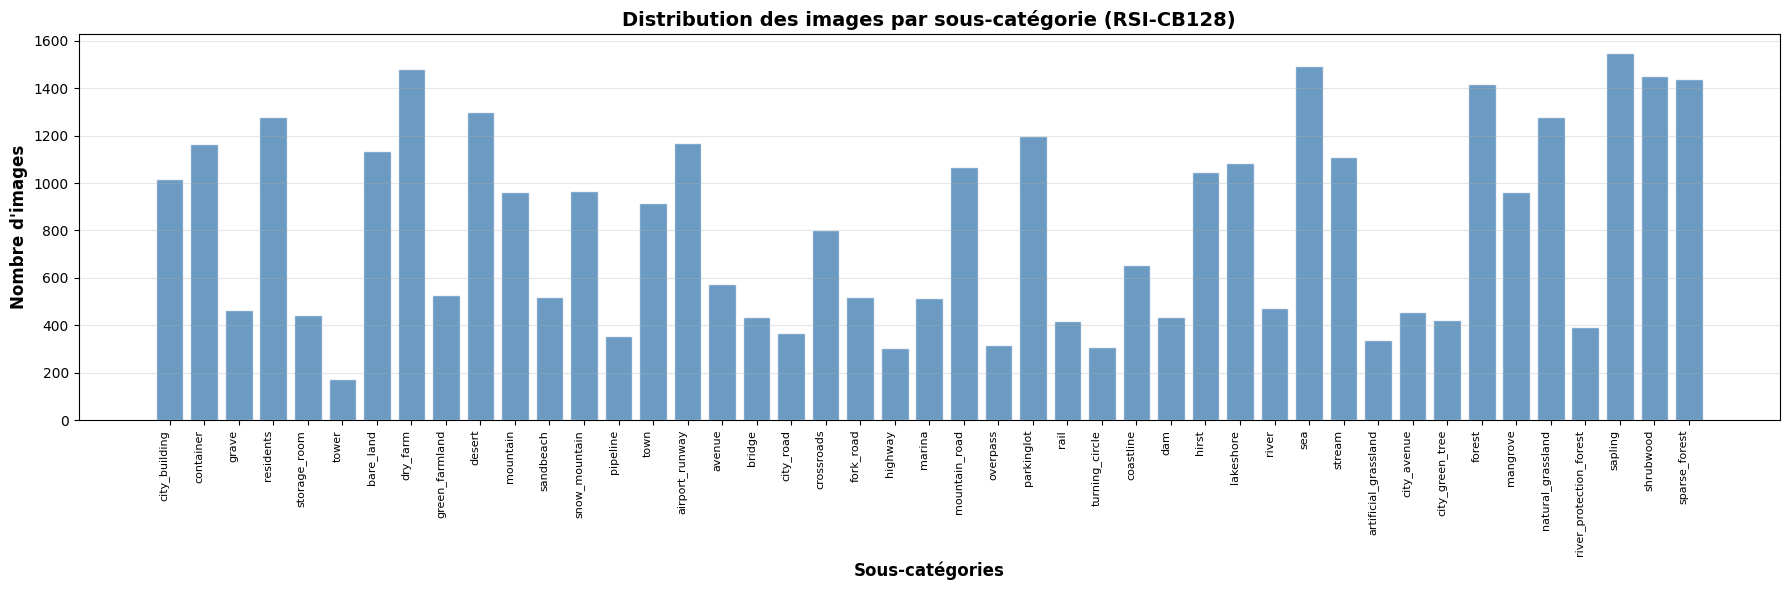


📊 Statistiques :
  • Moyenne  : 816 images/catégorie
  • Médiane  : 803 images/catégorie
  • Min      : 173 images
  • Max      : 1550 images


In [6]:
# Visualisation de la distribution des classes
subcats_names  = list(image_counts.keys())
subcats_values = list(image_counts.values())

plt.figure(figsize=(18, 6))
bars = plt.bar(range(len(subcats_names)), subcats_values, color='steelblue', alpha=0.8, edgecolor='white')
plt.xlabel('Sous-catégories', fontsize=12, fontweight='bold')
plt.ylabel("Nombre d'images", fontsize=12, fontweight='bold')
plt.title('Distribution des images par sous-catégorie (RSI-CB128)',
          fontsize=14, fontweight='bold')
plt.xticks(range(len(subcats_names)), subcats_names, rotation=90, ha='right', fontsize=8)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('01_distribution_classes.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Statistiques :")
print(f"  • Moyenne  : {np.mean(subcats_values):.0f} images/catégorie")
print(f"  • Médiane  : {np.median(subcats_values):.0f} images/catégorie")
print(f"  • Min      : {np.min(subcats_values)} images")
print(f"  • Max      : {np.max(subcats_values)} images")


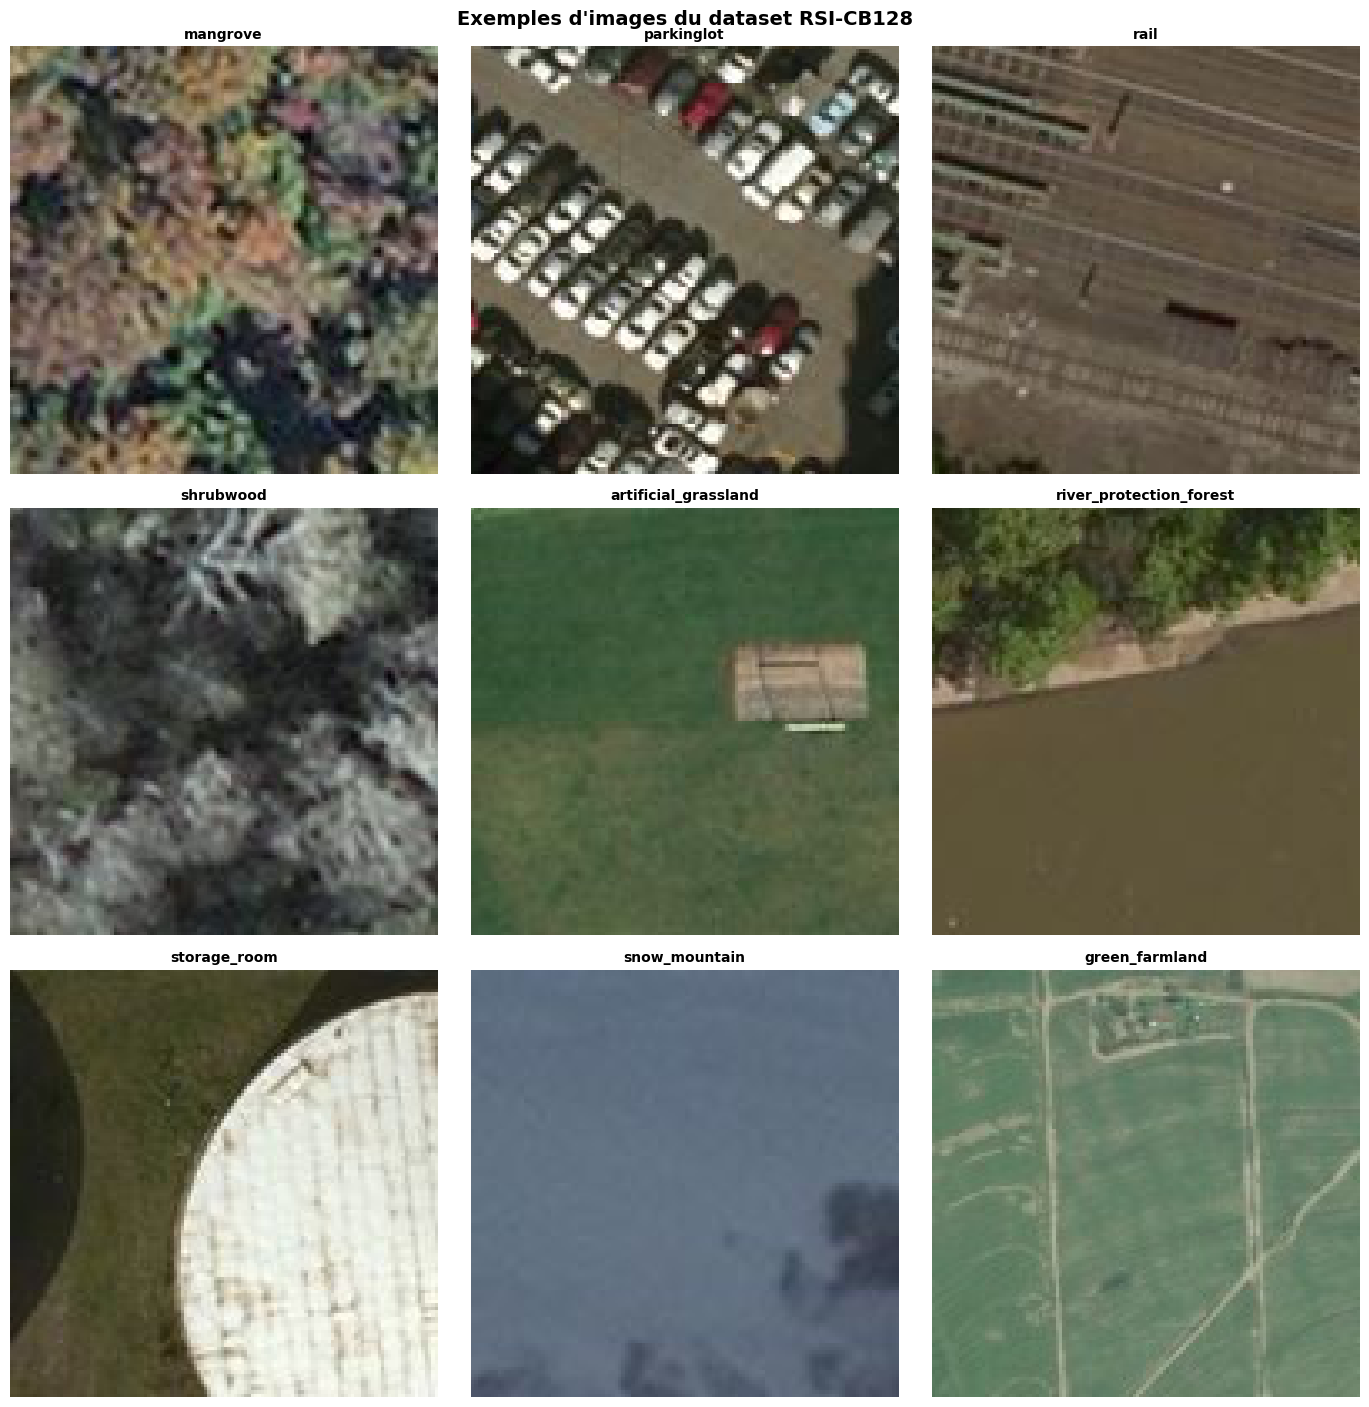

In [7]:
# Afficher des exemples d'images de chaque catégorie
np.random.seed(SEED)
sample_subcats = np.random.choice(subcats_names, size=9, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(14, 14))
axes = axes.ravel()

for idx, subcat in enumerate(sample_subcats):
    for cat in categories:
        subcat_path = os.path.join(BASE_PATH, cat, subcat)
        if os.path.exists(subcat_path):
            images = [f for f in os.listdir(subcat_path) if f.endswith('.tif')]
            if images:
                img = Image.open(os.path.join(subcat_path, images[0])).convert('RGB')
                axes[idx].imshow(img)
                axes[idx].set_title(f"{subcat}", fontsize=10, fontweight='bold')
                axes[idx].axis('off')
            break

plt.tight_layout()
plt.suptitle("Exemples d'images du dataset RSI-CB128",
             fontsize=14, fontweight='bold', y=1.002)
plt.savefig('02_exemples_images.png', dpi=150, bbox_inches='tight')
plt.show()


## 🏷️ 4. Préparation des Données

In [8]:
# Mapping classes → indices (trié alphabétiquement, identique à TensorFlow)
class_names   = sorted(subcats_names)
class_to_idx  = {name: idx for idx, name in enumerate(class_names)}
idx_to_class  = {idx: name for name, idx in class_to_idx.items()}
NUM_CLASSES   = len(class_names)

print(f"📋 Mapping des classes créé :")
print(f"  • Nombre total de classes : {NUM_CLASSES}\n")
print("Exemples de classes :")
for i in range(min(10, NUM_CLASSES)):
    print(f"  {i:2d} → {class_names[i]}")
print("  ...")


📋 Mapping des classes créé :
  • Nombre total de classes : 45

Exemples de classes :
   0 → airport_runway
   1 → artificial_grassland
   2 → avenue
   3 → bare_land
   4 → bridge
   5 → city_avenue
   6 → city_building
   7 → city_green_tree
   8 → city_road
   9 → coastline
  ...


In [9]:
# Charger tous les chemins d'images et leurs labels
def load_image_paths_and_labels():
    image_paths = []
    labels      = []
    for cat in categories:
        cat_path = os.path.join(BASE_PATH, cat)
        subcats  = [d for d in os.listdir(cat_path)
                    if os.path.isdir(os.path.join(cat_path, d))]
        for subcat in subcats:
            subcat_path = os.path.join(cat_path, subcat)
            imgs = [f for f in os.listdir(subcat_path) if f.lower().endswith('.tif')]
            for img_name in imgs:
                image_paths.append(os.path.join(subcat_path, img_name))
                labels.append(class_to_idx[subcat])
    return np.array(image_paths), np.array(labels)

print("📂 Chargement des chemins d'images...")
all_image_paths, all_labels = load_image_paths_and_labels()
print(f"✅ Chargement terminé !")
print(f"  • Total images : {len(all_image_paths)}")
print(f"  • Total labels : {len(all_labels)}")


📂 Chargement des chemins d'images...
✅ Chargement terminé !
  • Total images : 36707
  • Total labels : 36707


In [10]:
# Split identique au notebook TensorFlow
# Split 1 : Séparer test set (10%)
X_temp, X_test, y_temp, y_test = train_test_split(
    all_image_paths, all_labels,
    test_size=TEST_SPLIT,
    random_state=SEED,
    stratify=all_labels
)

# Split 2 : Séparer train et validation (20% de temp)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=VALIDATION_SPLIT,
    random_state=SEED,
    stratify=y_temp
)

print("📊 RÉPARTITION DES DONNÉES :")
print(f"  • Training set   : {len(X_train):5d} images ({len(X_train)/len(all_image_paths)*100:.1f}%)")
print(f"  • Validation set : {len(X_val):5d} images ({len(X_val)/len(all_image_paths)*100:.1f}%)")
print(f"  • Test set       : {len(X_test):5d} images ({len(X_test)/len(all_image_paths)*100:.1f}%)")
print(f"  • TOTAL          : {len(all_image_paths):5d} images")


📊 RÉPARTITION DES DONNÉES :
  • Training set   : 26428 images (72.0%)
  • Validation set :  6608 images (18.0%)
  • Test set       :  3671 images (10.0%)
  • TOTAL          : 36707 images


## 🔄 5. Dataset et DataLoaders PyTorch

In [11]:
# Transformations — même logique que TensorFlow :
#   • Normalisation : /255.0 → on utilise mean=0.5 std=0.5 (équivalent centrage)
#   • Augmentation sur le train uniquement

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),               # [0,1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])  # → [-1, 1]
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

print("✅ Transformations définies !")
print("\n📊 Augmentation (Training) :")
print("  • Rotation         : ±20°")
print("  • Flip horizontal  : Oui (p=0.5)")
print("  • Flip vertical    : Oui (p=0.5)")
print("  • ColorJitter      : brightness/contrast/saturation ±20%")
print("  • Normalisation    : mean=0.5  std=0.5")
print("\n📊 Validation / Test (pas d'augmentation):")
print("  • Resize + ToTensor + Normalisation uniquement")


✅ Transformations définies !

📊 Augmentation (Training) :
  • Rotation         : ±20°
  • Flip horizontal  : Oui (p=0.5)
  • Flip vertical    : Oui (p=0.5)
  • ColorJitter      : brightness/contrast/saturation ±20%
  • Normalisation    : mean=0.5  std=0.5

📊 Validation / Test (pas d'augmentation):
  • Resize + ToTensor + Normalisation uniquement


In [12]:
class RSIDataset(Dataset):
    """
    Dataset PyTorch pour les images RSI-CB128 (.tif)
    Charge les images à la volée (comme le générateur TensorFlow)
    """
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels      = labels
        self.transform   = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label    = self.labels[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception:
            image = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color=(0, 0, 0))

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)


# Créer les datasets
train_dataset = RSIDataset(X_train, y_train, transform=train_transforms)
val_dataset   = RSIDataset(X_val,   y_val,   transform=val_test_transforms)
test_dataset  = RSIDataset(X_test,  y_test,  transform=val_test_transforms)

print("✅ Datasets PyTorch créés !")
print(f"  • Train      : {len(train_dataset)} images")
print(f"  • Validation : {len(val_dataset)} images")
print(f"  • Test       : {len(test_dataset)} images")


✅ Datasets PyTorch créés !
  • Train      : 26428 images
  • Validation : 6608 images
  • Test       : 3671 images


In [13]:
# Créer les DataLoaders
NUM_WORKERS = 0  # 0 pour Windows

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

steps_per_epoch  = len(train_loader)
validation_steps = len(val_loader)

print("✅ DataLoaders créés !")
print(f"  • Train loader      : {len(train_loader)} batches")
print(f"  • Validation loader : {len(val_loader)} batches")
print(f"  • Test loader       : {len(test_loader)} batches")
print(f"\n📊 Configuration :")
print(f"  • Steps per epoch   : {steps_per_epoch}")
print(f"  • Validation steps  : {validation_steps}")
print(f"  • Temps estimé      : ~{EPOCHS * steps_per_epoch // 60} minutes")


✅ DataLoaders créés !
  • Train loader      : 826 batches
  • Validation loader : 207 batches
  • Test loader       : 115 batches

📊 Configuration :
  • Steps per epoch   : 826
  • Validation steps  : 207
  • Temps estimé      : ~275 minutes


🧪 Test du DataLoader :
  • Shape images : torch.Size([32, 3, 128, 128])
  • Shape labels : torch.Size([32])
  • Type images  : torch.float32
  • Min/Max      : -1.000 / 1.000
✅ Test réussi !


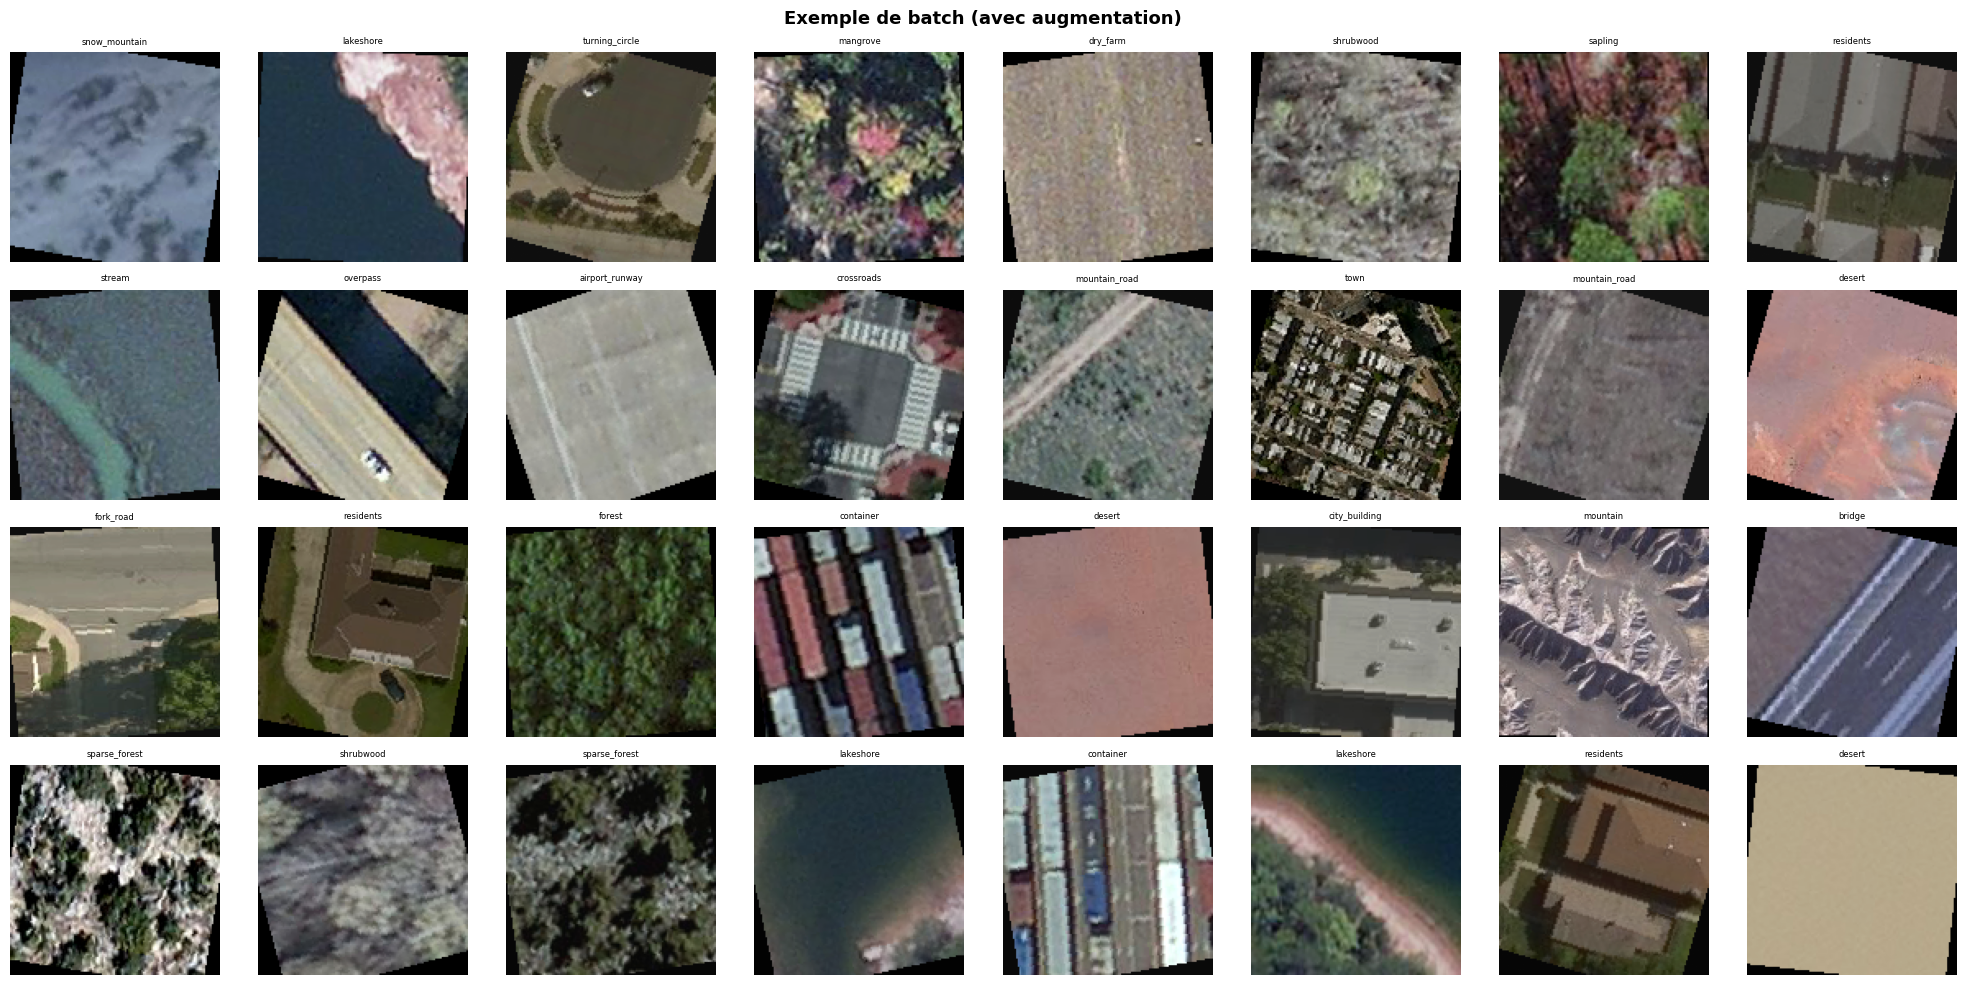

In [14]:
# Test du DataLoader — vérification d'un batch
images_batch, labels_batch = next(iter(train_loader))
print("🧪 Test du DataLoader :")
print(f"  • Shape images : {images_batch.shape}")
print(f"  • Shape labels : {labels_batch.shape}")
print(f"  • Type images  : {images_batch.dtype}")
print(f"  • Min/Max      : {images_batch.min():.3f} / {images_batch.max():.3f}")
print("✅ Test réussi !")

# Visualiser un batch
def denormalize(tensor):
    """Dénormaliser (mean=0.5, std=0.5) pour affichage."""
    return tensor * 0.5 + 0.5

fig, axes = plt.subplots(4, 8, figsize=(20, 10))
axes = axes.ravel()
for i in range(min(32, len(images_batch))):
    img = denormalize(images_batch[i]).permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    axes[i].imshow(img)
    axes[i].set_title(class_names[labels_batch[i].item()], fontsize=6)
    axes[i].axis('off')
plt.suptitle("Exemple de batch (avec augmentation)", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('03_exemple_batch.png', dpi=150, bbox_inches='tight')
plt.show()


## 🧠 6. Architecture CNN (identique à TensorFlow)

In [15]:
class RSI_CNN(nn.Module):
    """
    CNN pour RSI-CB128 — architecture miroir du modèle TensorFlow :
      Bloc 1 : Conv(32)  + BN + ReLU + MaxPool
      Bloc 2 : Conv(64)  + BN + ReLU + MaxPool
      Bloc 3 : Conv(128) + BN + ReLU + MaxPool
      Bloc 4 : Conv(256) + BN + ReLU + MaxPool
      FC     : Flatten → Dense(512) → Dropout(0.5)
               → Dense(256) → Dropout(0.3)
               → Dense(NUM_CLASSES) → Softmax
    """
    def __init__(self, num_classes):
        super(RSI_CNN, self).__init__()

        # Bloc 1 — 32 filtres
        self.block1 = nn.Sequential(
            nn.Conv2d(3,  32, kernel_size=3, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)            # 128→63
        )

        # Bloc 2 — 64 filtres
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)            # 63→30
        )

        # Bloc 3 — 128 filtres
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)            # 30→14
        )

        # Bloc 4 — 256 filtres
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)            # 14→6
        )

        # Calculer la taille du Flatten automatiquement
        self._flat_size = self._get_flat_size()

        # FC — identique TensorFlow
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self._flat_size, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def _get_flat_size(self):
        """Calcule automatiquement la taille après les blocs conv."""
        with torch.no_grad():
            dummy = torch.zeros(1, 3, IMG_SIZE, IMG_SIZE)
            x = self.block1(dummy)
            x = self.block2(x)
            x = self.block3(x)
            x = self.block4(x)
            return int(np.prod(x.shape[1:]))

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.classifier(x)
        return x


# Instancier le modèle
model = RSI_CNN(num_classes=NUM_CLASSES).to(device)
print("✅ Modèle RSI_CNN créé !")


✅ Modèle RSI_CNN créé !


In [16]:
# Résumé du modèle
def count_parameters(model):
    total     = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

total_params, trainable_params = count_parameters(model)

print("=" * 60)
print("📋 RÉSUMÉ DU MODÈLE RSI_CNN")
print("=" * 60)
print(f"  • Architecture    : 4 blocs Conv + FC")
print(f"  • Input shape     : ({IMG_SIZE}, {IMG_SIZE}, 3)")
print(f"  • Output shape    : ({NUM_CLASSES},)")
print(f"  • Filtres         : 32 → 64 → 128 → 256")
print(f"  • Couches denses  : 512 → 256 → {NUM_CLASSES}")
print(f"  • Dropout         : 0.5 / 0.3")
print(f"  • Paramètres totaux      : {total_params:,}")
print(f"  • Paramètres entraînables: {trainable_params:,}")
print(f"  • Taille modèle  : {total_params*4/1e6:.2f} MB")
print(f"  • Device         : {device}")
print("=" * 60)

# Test forward pass
with torch.no_grad():
    dummy = torch.zeros(1, 3, IMG_SIZE, IMG_SIZE).to(device)
    out   = model(dummy)
print(f"\n🧪 Test forward pass : input{list(dummy.shape)} → output{list(out.shape)}")
print("✅ Modèle opérationnel !")


📋 RÉSUMÉ DU MODÈLE RSI_CNN
  • Architecture    : 4 blocs Conv + FC
  • Input shape     : (128, 128, 3)
  • Output shape    : (45,)
  • Filtres         : 32 → 64 → 128 → 256
  • Couches denses  : 512 → 256 → 45
  • Dropout         : 0.5 / 0.3
  • Paramètres totaux      : 5,251,373
  • Paramètres entraînables: 5,251,373
  • Taille modèle  : 21.01 MB
  • Device         : cuda

🧪 Test forward pass : input[1, 3, 128, 128] → output[1, 45]
✅ Modèle opérationnel !


## ⚙️ 7. Optimiseur et Callbacks

In [17]:
# Fonction de perte
criterion = nn.CrossEntropyLoss()

# Optimiseur Adam (identique TensorFlow)
optimizer = optim.Adam(model.parameters(), lr=LR)

# ReduceLROnPlateau (identique TensorFlow : factor=0.5, patience=3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=True
)

# EarlyStopping — implémentation manuelle (patience=5 comme TensorFlow)
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best=True):
        self.patience     = patience
        self.min_delta    = min_delta
        self.restore_best = restore_best
        self.counter      = 0
        self.best_loss    = None
        self.best_weights = None
        self.stop         = False

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss    = val_loss
            self.counter      = 0
            if self.restore_best:
                self.best_weights = {k: v.clone() for k, v in model.state_dict().items()}
        else:
            self.counter += 1
            print(f"  ⚠️  EarlyStopping : {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.stop = True
                if self.restore_best and self.best_weights is not None:
                    model.load_state_dict(self.best_weights)
                    print("  ✅ Meilleurs poids restaurés !")

early_stopping = EarlyStopping(patience=5, restore_best=True)

print("✅ Callbacks configurés !")
print("  • EarlyStopping        (patience=5, restore_best_weights=True)")
print("  • ReduceLROnPlateau    (factor=0.5, patience=3, min_lr=1e-7)")
print("  • ModelCheckpoint      (sauvegarde automatique du meilleur modèle)")


✅ Callbacks configurés !
  • EarlyStopping        (patience=5, restore_best_weights=True)
  • ReduceLROnPlateau    (factor=0.5, patience=3, min_lr=1e-7)
  • ModelCheckpoint      (sauvegarde automatique du meilleur modèle)


d:\M2 SEMESTRE1\NLP\pytorchenv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 🏋️ 8. Entraînement

In [18]:
from tqdm import tqdm

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total   = 0
    pbar = tqdm(loader, desc='  Train', leave=False, unit='batch')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total   += labels.size(0)
        correct += (predicted == labels).sum().item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}',
                          'acc':  f'{100*correct/total:.2f}%'})
    return running_loss / total, 100.0 * correct / total


def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total   = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss    = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total   += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / total, 100.0 * correct / total

print("✅ Fonctions train_one_epoch() et validate() prêtes !")


✅ Fonctions train_one_epoch() et validate() prêtes !


In [19]:
import time, os

os.makedirs('models', exist_ok=True)

history = {
    'loss': [], 'accuracy': [],
    'val_loss': [], 'val_accuracy': [],
    'learning_rates': []
}

best_val_acc  = 0.0
best_epoch    = 0

print("=" * 70)
print("🚀 DÉBUT DE L'ENTRAÎNEMENT")
print("=" * 70)
print(f"  • Epochs    : {EPOCHS}")
print(f"  • Batch     : {BATCH_SIZE}")
print(f"  • LR init   : {LR}")
print(f"  • Device    : {device}")
print(f"  • Train     : {len(train_dataset)} images")
print(f"  • Val       : {len(val_dataset)} images")
print()

t_start = time.time()

for epoch in range(1, EPOCHS + 1):
    t_epoch = time.time()
    print(f"Epoch [{epoch}/{EPOCHS}]")
    print("-" * 70)

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss,   val_acc   = validate(model, val_loader, criterion, device)

    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    history['loss'].append(train_loss)
    history['accuracy'].append(train_acc / 100)      # stocker en [0,1] comme TF
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc / 100)
    history['learning_rates'].append(current_lr)

    epoch_time = time.time() - t_epoch

    print(f"  Train Loss : {train_loss:.4f}  |  Train Acc : {train_acc:.2f}%")
    print(f"  Val Loss   : {val_loss:.4f}  |  Val Acc   : {val_acc:.2f}%")
    print(f"  LR courant : {current_lr:.2e}  |  Temps     : {epoch_time:.1f}s")

    # ModelCheckpoint — sauvegarder le meilleur modèle
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch   = epoch
        torch.save({
            'epoch':              epoch,
            'model_state_dict':   model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss':           val_loss,
            'val_acc':            val_acc,
            'num_classes':        NUM_CLASSES,
            'classes':            class_names,
        }, 'models/best_model.pth')
        print(f"  ✅ Meilleur modèle sauvegardé ! (Val Acc : {val_acc:.2f}%)")

    # EarlyStopping
    early_stopping(val_loss, model)
    print("-" * 70)
    if early_stopping.stop:
        print(f"\n🛑 Early stopping déclenché à l'epoch {epoch} !")
        break

total_time = time.time() - t_start
print("\n" + "=" * 70)
print("✅ ENTRAÎNEMENT TERMINÉ !")
print("=" * 70)
print(f"  • Temps total         : {total_time/60:.1f} minutes")
print(f"  • Meilleure val acc   : {best_val_acc:.2f}%  (epoch {best_epoch})")
print(f"  • Modèle sauvegardé   : models/best_model.pth")


🚀 DÉBUT DE L'ENTRAÎNEMENT
  • Epochs    : 20
  • Batch     : 32
  • LR init   : 0.001
  • Device    : cuda
  • Train     : 26428 images
  • Val       : 6608 images

Epoch [1/20]
----------------------------------------------------------------------


  Train Loss : 2.3620  |  Train Acc : 32.37%
  Val Loss   : 1.2892  |  Val Acc   : 60.94%
  LR courant : 1.00e-03  |  Temps     : 367.3s
  ✅ Meilleur modèle sauvegardé ! (Val Acc : 60.94%)
----------------------------------------------------------------------
Epoch [2/20]
----------------------------------------------------------------------


  Train Loss : 1.5954  |  Train Acc : 52.96%
  Val Loss   : 0.9416  |  Val Acc   : 73.49%
  LR courant : 1.00e-03  |  Temps     : 126.7s
  ✅ Meilleur modèle sauvegardé ! (Val Acc : 73.49%)
----------------------------------------------------------------------
Epoch [3/20]
----------------------------------------------------------------------


  Train Loss : 1.3001  |  Train Acc : 61.99%
  Val Loss   : 0.7851  |  Val Acc   : 77.30%
  LR courant : 1.00e-03  |  Temps     : 125.8s
  ✅ Meilleur modèle sauvegardé ! (Val Acc : 77.30%)
----------------------------------------------------------------------
Epoch [4/20]
----------------------------------------------------------------------


  Train Loss : 1.1402  |  Train Acc : 66.46%
  Val Loss   : 0.6745  |  Val Acc   : 81.20%
  LR courant : 1.00e-03  |  Temps     : 126.4s
  ✅ Meilleur modèle sauvegardé ! (Val Acc : 81.20%)
----------------------------------------------------------------------
Epoch [5/20]
----------------------------------------------------------------------


  Train Loss : 1.0268  |  Train Acc : 70.07%
  Val Loss   : 0.5412  |  Val Acc   : 84.70%
  LR courant : 1.00e-03  |  Temps     : 125.8s
  ✅ Meilleur modèle sauvegardé ! (Val Acc : 84.70%)
----------------------------------------------------------------------
Epoch [6/20]
----------------------------------------------------------------------


  Train Loss : 0.9393  |  Train Acc : 72.54%
  Val Loss   : 0.4907  |  Val Acc   : 85.34%
  LR courant : 1.00e-03  |  Temps     : 124.0s
  ✅ Meilleur modèle sauvegardé ! (Val Acc : 85.34%)
----------------------------------------------------------------------
Epoch [7/20]
----------------------------------------------------------------------


  Train Loss : 0.8693  |  Train Acc : 74.21%
  Val Loss   : 0.4457  |  Val Acc   : 87.67%
  LR courant : 1.00e-03  |  Temps     : 125.0s
  ✅ Meilleur modèle sauvegardé ! (Val Acc : 87.67%)
----------------------------------------------------------------------
Epoch [8/20]
----------------------------------------------------------------------


  Train Loss : 0.8114  |  Train Acc : 76.05%
  Val Loss   : 0.4219  |  Val Acc   : 87.52%
  LR courant : 1.00e-03  |  Temps     : 120.0s
----------------------------------------------------------------------
Epoch [9/20]
----------------------------------------------------------------------


  Train Loss : 0.7695  |  Train Acc : 77.69%
  Val Loss   : 0.4071  |  Val Acc   : 89.03%
  LR courant : 1.00e-03  |  Temps     : 116.9s
  ✅ Meilleur modèle sauvegardé ! (Val Acc : 89.03%)
----------------------------------------------------------------------
Epoch [10/20]
----------------------------------------------------------------------


  Train Loss : 0.7016  |  Train Acc : 79.32%
  Val Loss   : 0.3607  |  Val Acc   : 88.98%
  LR courant : 1.00e-03  |  Temps     : 114.5s
----------------------------------------------------------------------
Epoch [11/20]
----------------------------------------------------------------------


  Train Loss : 0.6841  |  Train Acc : 79.82%
  Val Loss   : 0.3872  |  Val Acc   : 88.71%
  LR courant : 1.00e-03  |  Temps     : 126.0s
  ⚠️  EarlyStopping : 1/5
----------------------------------------------------------------------
Epoch [12/20]
----------------------------------------------------------------------


  Train Loss : 0.6511  |  Train Acc : 81.24%
  Val Loss   : 0.3355  |  Val Acc   : 90.56%
  LR courant : 1.00e-03  |  Temps     : 126.0s
  ✅ Meilleur modèle sauvegardé ! (Val Acc : 90.56%)
----------------------------------------------------------------------
Epoch [13/20]
----------------------------------------------------------------------


  Train Loss : 0.6052  |  Train Acc : 82.33%
  Val Loss   : 0.3001  |  Val Acc   : 91.01%
  LR courant : 1.00e-03  |  Temps     : 123.4s
  ✅ Meilleur modèle sauvegardé ! (Val Acc : 91.01%)
----------------------------------------------------------------------
Epoch [14/20]
----------------------------------------------------------------------


  Train Loss : 0.5750  |  Train Acc : 83.10%
  Val Loss   : 0.3240  |  Val Acc   : 91.04%
  LR courant : 1.00e-03  |  Temps     : 126.9s
  ✅ Meilleur modèle sauvegardé ! (Val Acc : 91.04%)
  ⚠️  EarlyStopping : 1/5
----------------------------------------------------------------------
Epoch [15/20]
----------------------------------------------------------------------


  Train Loss : 0.5534  |  Train Acc : 83.70%
  Val Loss   : 0.2562  |  Val Acc   : 93.13%
  LR courant : 1.00e-03  |  Temps     : 125.1s
  ✅ Meilleur modèle sauvegardé ! (Val Acc : 93.13%)
----------------------------------------------------------------------
Epoch [16/20]
----------------------------------------------------------------------


  Train Loss : 0.5289  |  Train Acc : 84.53%
  Val Loss   : 0.2479  |  Val Acc   : 92.95%
  LR courant : 1.00e-03  |  Temps     : 126.3s
----------------------------------------------------------------------
Epoch [17/20]
----------------------------------------------------------------------


  Train Loss : 0.4882  |  Train Acc : 85.53%
  Val Loss   : 0.3019  |  Val Acc   : 91.80%
  LR courant : 1.00e-03  |  Temps     : 125.7s
  ⚠️  EarlyStopping : 1/5
----------------------------------------------------------------------
Epoch [18/20]
----------------------------------------------------------------------


  Train Loss : 0.4653  |  Train Acc : 86.60%
  Val Loss   : 0.2539  |  Val Acc   : 93.02%
  LR courant : 1.00e-03  |  Temps     : 126.3s
  ⚠️  EarlyStopping : 2/5
----------------------------------------------------------------------
Epoch [19/20]
----------------------------------------------------------------------


  Train Loss : 0.4611  |  Train Acc : 86.66%
  Val Loss   : 0.2125  |  Val Acc   : 93.81%
  LR courant : 1.00e-03  |  Temps     : 200.8s
  ✅ Meilleur modèle sauvegardé ! (Val Acc : 93.81%)
----------------------------------------------------------------------
Epoch [20/20]
----------------------------------------------------------------------


  Train Loss : 0.4465  |  Train Acc : 87.03%
  Val Loss   : 0.2303  |  Val Acc   : 93.04%
  LR courant : 1.00e-03  |  Temps     : 403.9s
  ⚠️  EarlyStopping : 1/5
----------------------------------------------------------------------

✅ ENTRAÎNEMENT TERMINÉ !
  • Temps total         : 51.4 minutes
  • Meilleure val acc   : 93.81%  (epoch 19)
  • Modèle sauvegardé   : models/best_model.pth


## 📊 9. Courbes d'Apprentissage

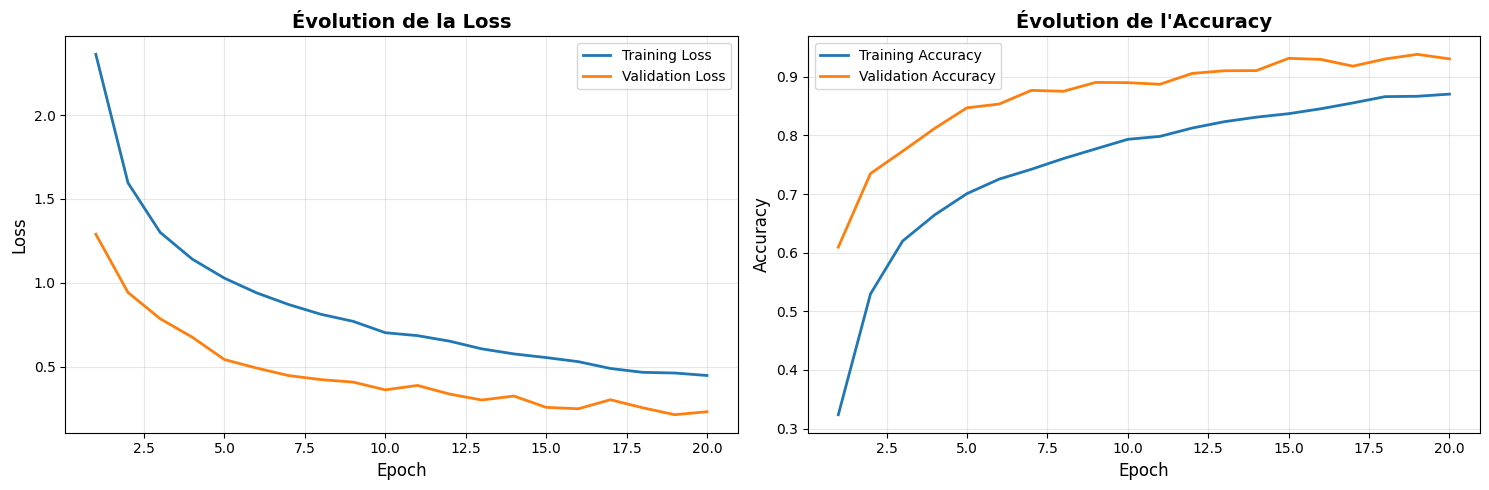


📊 PERFORMANCES DU MODÈLE :
  • Meilleure accuracy training   : 0.8703 (87.03%)
  • Meilleure accuracy validation : 0.9381 (93.81%)
  • Loss finale training          : 0.4465
  • Loss finale validation        : 0.2303


In [20]:
# Visualiser les courbes — même style que TensorFlow
epochs_range = range(1, len(history['loss']) + 1)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Courbe de Loss
axes[0].plot(epochs_range, history['loss'],     label='Training Loss',   linewidth=2)
axes[0].plot(epochs_range, history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title("Évolution de la Loss",  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss',  fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Courbe d'Accuracy
axes[1].plot(epochs_range, history['accuracy'],     label='Training Accuracy',   linewidth=2)
axes[1].plot(epochs_range, history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_title("Évolution de l'Accuracy", fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('04_courbes_apprentissage.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 PERFORMANCES DU MODÈLE :")
print(f"  • Meilleure accuracy training   : {max(history['accuracy']):.4f} ({max(history['accuracy'])*100:.2f}%)")
print(f"  • Meilleure accuracy validation : {max(history['val_accuracy']):.4f} ({max(history['val_accuracy'])*100:.2f}%)")
print(f"  • Loss finale training          : {history['loss'][-1]:.4f}")
print(f"  • Loss finale validation        : {history['val_loss'][-1]:.4f}")


## 🧪 10. Évaluation sur le Test Set

In [21]:
# Charger le meilleur modèle (comme restore_best_weights=True en TF)
checkpoint = torch.load('models/best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✅ Meilleur modèle chargé (epoch {checkpoint['epoch']}, val_acc={checkpoint['val_acc']:.2f}%)")

print("\n🧪 ÉVALUATION SUR LE TEST SET...\n")

test_loss, test_accuracy = validate(model, test_loader, criterion, device)

print(f"\n📊 RÉSULTATS SUR LE TEST SET :")
print(f"  • Test Loss     : {test_loss:.4f}")
print(f"  • Test Accuracy : {test_accuracy:.4f} ({test_accuracy:.2f}%)")


✅ Meilleur modèle chargé (epoch 19, val_acc=93.81%)

🧪 ÉVALUATION SUR LE TEST SET...



C:\Users\mappo\AppData\Local\Temp\ipykernel_12952\817557153.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('models/best_model.pth', map_location


📊 RÉSULTATS SUR LE TEST SET :
  • Test Loss     : 0.2188
  • Test Accuracy : 93.4078 (93.41%)


In [22]:
# Générer toutes les prédictions sur le test set
print("🔮 Génération des prédictions sur le test set...\n")

model.eval()
all_preds   = []
all_targets = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Test'):
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.numpy())

all_preds   = np.array(all_preds)
all_targets = np.array(all_targets)

print(f"✅ Prédictions générées pour {len(all_preds)} images")

# Matrice de confusion
cm = confusion_matrix(all_targets, all_preds)
print(f"\n📊 Matrice de confusion calculée ({cm.shape[0]}×{cm.shape[1]})")


🔮 Génération des prédictions sur le test set...



Test: 100%|██████████| 115/115 [00:08<00:00, 13.51it/s]

✅ Prédictions générées pour 3671 images

📊 Matrice de confusion calculée (45×45)


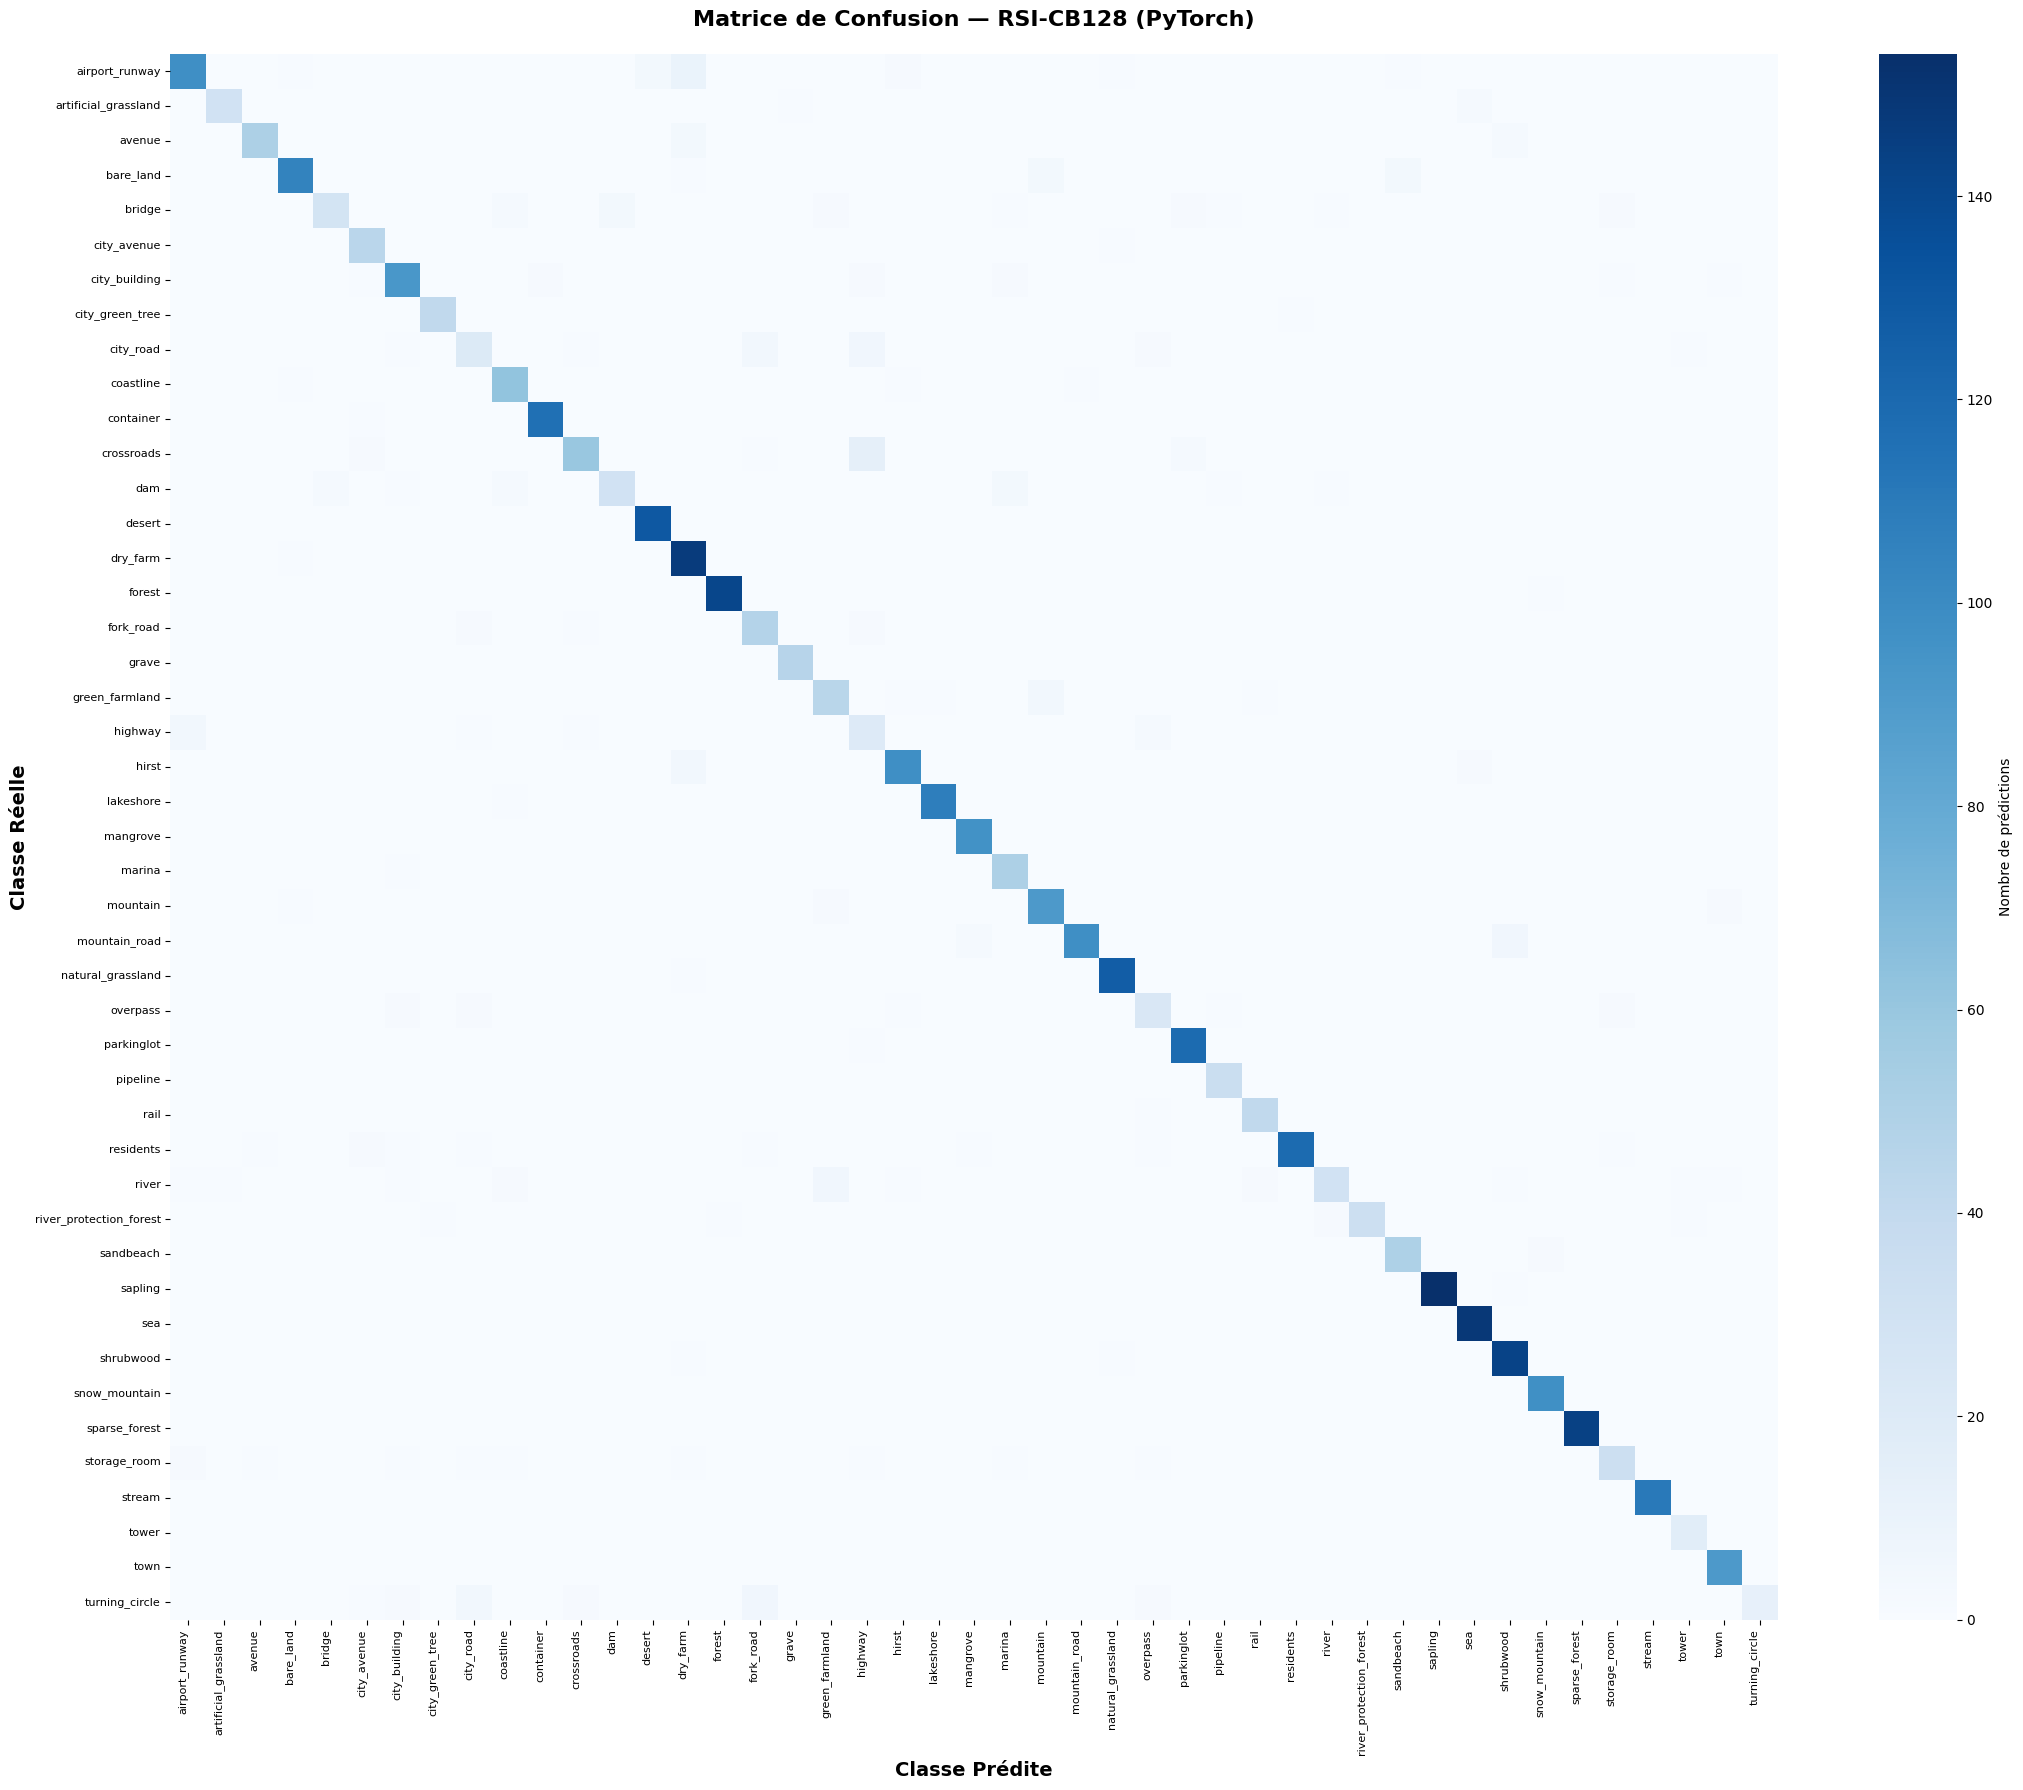


📊 TOP 10 MEILLEURES CLASSES :
  mangrove                       : 100.00%
  pipeline                       : 100.00%
  tower                          : 100.00%
  stream                         : 100.00%
  desert                         : 100.00%
  sparse_forest                  : 100.00%
  snow_mountain                  : 100.00%
  sea                            : 100.00%
  grave                          : 100.00%
  town                           : 100.00%

📊 TOP 10 PIRES CLASSES :
  turning_circle                 : 41.94%
  city_road                      : 56.76%
  bridge                         : 63.64%
  river                          : 63.83%
  highway                        : 66.67%
  dam                            : 69.77%
  overpass                       : 75.00%
  crossroads                     : 75.00%
  storage_room                   : 77.27%
  airport_runway                 : 83.76%


In [23]:
# Visualiser la matrice de confusion
plt.figure(figsize=(22, 18))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Nombre de prédictions'})
plt.title('Matrice de Confusion — RSI-CB128 (PyTorch)',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Classe Prédite',  fontsize=14, fontweight='bold')
plt.ylabel('Classe Réelle',   fontsize=14, fontweight='bold')
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.yticks(rotation=0,           fontsize=8)
plt.tight_layout()
plt.savefig('05_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Accuracy par classe
class_accuracies = cm.diagonal() / cm.sum(axis=1)

print("\n📊 TOP 10 MEILLEURES CLASSES :")
for idx in np.argsort(class_accuracies)[-10:][::-1]:
    print(f"  {class_names[idx]:30s} : {class_accuracies[idx]*100:.2f}%")

print("\n📊 TOP 10 PIRES CLASSES :")
for idx in np.argsort(class_accuracies)[:10]:
    print(f"  {class_names[idx]:30s} : {class_accuracies[idx]*100:.2f}%")


In [24]:
# Rapport de classification détaillé (identique TF)
print("📋 RAPPORT DE CLASSIFICATION DÉTAILLÉ:\n")
print("="*80)

report = classification_report(
    all_targets, all_preds,
    target_names=class_names,
    digits=4
)
print(report)
print("="*80)

# Sauvegarder
with open('classification_report.txt', 'w', encoding='utf-8') as f:
    f.write("RAPPORT DE CLASSIFICATION — RSI-CB128 CNN PYTORCH\n")
    f.write("="*80 + "\n\n")
    f.write(report)
    f.write("\n" + "="*80 + "\n")

print("\n✅ Rapport sauvegardé dans 'classification_report.txt'")


📋 RAPPORT DE CLASSIFICATION DÉTAILLÉ:

                         precision    recall  f1-score   support

         airport_runway     0.9245    0.8376    0.8789       117
   artificial_grassland     0.9677    0.8824    0.9231        34
                 avenue     0.9623    0.8793    0.9189        58
              bare_land     0.9633    0.9211    0.9417       114
                 bridge     0.9032    0.6364    0.7467        44
            city_avenue     0.8627    0.9778    0.9167        45
          city_building     0.9029    0.9118    0.9073       102
        city_green_tree     0.9762    0.9762    0.9762        42
              city_road     0.6364    0.5676    0.6000        37
              coastline     0.8611    0.9538    0.9051        65
              container     0.9831    0.9915    0.9872       117
             crossroads     0.9231    0.7500    0.8276        80
                    dam     0.8824    0.6977    0.7792        43
                 desert     0.9701    1.0000    0.

## 💾 11. Sauvegarde du Modèle et des Métadonnées

In [25]:
import pickle
import json
from datetime import datetime

print("💾 SAUVEGARDE DU MODÈLE ET DES MÉTADONNÉES...\n")
os.makedirs('models', exist_ok=True)

# 1. Modèle final complet
torch.save({
    'model_state_dict':     model.state_dict(),
    'architecture':         'RSI_CNN',
    'num_classes':          NUM_CLASSES,
    'img_size':             IMG_SIZE,
    'best_val_acc':         best_val_acc,
    'val_loss':             history['val_loss'][best_epoch - 1],
    'epoch':                best_epoch,
    'class_names':          class_names,
    'optimizer_state_dict': optimizer.state_dict(),
    'training_date':        str(datetime.now()),
}, 'models/best_model.pth')
print("✅ Modèle sauvegardé            : models/best_model.pth")

# 2. Historique d'entraînement (pickle — même format TF)
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history, f)
print("✅ Historique sauvegardé        : training_history.pkl")

# 3. Noms de classes
with open('class_names.pkl', 'wb') as f:
    pickle.dump(class_names, f)
print("✅ Classes sauvegardées         : class_names.pkl")

# 4. Mappings
mappings = {'class_to_idx': class_to_idx, 'idx_to_class': idx_to_class}
with open('class_mappings.pkl', 'wb') as f:
    pickle.dump(mappings, f)
print("✅ Mappings sauvegardés         : class_mappings.pkl")

# 5. Métadonnées JSON (même structure que TF pour compatibilité app)
metadata = {
    'model_name':        'RSI-CB128 CNN PyTorch Classifier',
    'date_created':      datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'img_size':          IMG_SIZE,
    'num_classes':       NUM_CLASSES,
    'total_params':      total_params,
    'test_accuracy':     float(test_accuracy / 100),
    'test_loss':         float(test_loss),
    'epochs_trained':    len(history['loss']),
    'best_val_accuracy': float(best_val_acc / 100),
    'best_epoch':        best_epoch,
    'classes':           class_names,
    'framework':         'PyTorch',
}
with open('model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)
print("✅ Métadonnées sauvegardées     : model_metadata.json")

# 6. model_info.json (pour l'app Streamlit PyTorch)
model_info = {
    'model_name':          'RSI_CNN',
    'num_classes':         NUM_CLASSES,
    'classes':             class_names,
    'img_size':            IMG_SIZE,
    'best_epoch':          best_epoch,
    'best_val_acc':        float(best_val_acc),
    'test_acc':            float(test_accuracy),
    'test_loss':           float(test_loss),
    'train_size':          len(train_dataset),
    'val_size':            len(val_dataset),
    'test_size':           len(test_dataset),
    'batch_size':          BATCH_SIZE,
    'learning_rate':       LR,
    'num_epochs':          EPOCHS,
    'total_parameters':    total_params,
    'trainable_parameters':trainable_params,
}
with open('models/model_info.json', 'w') as f:
    json.dump(model_info, f, indent=4)
print("✅ model_info.json sauvegardé   : models/model_info.json")

print(f"\n🎉 TOUT EST SAUVEGARDÉ !")
print(f"\nFichiers créés :")
print(f"  📦 models/best_model.pth")
print(f"  📄 models/model_info.json")
print(f"  📊 training_history.pkl")
print(f"  📋 class_names.pkl")
print(f"  🗂️  class_mappings.pkl")
print(f"  📄 model_metadata.json")
print(f"  📄 classification_report.txt")


💾 SAUVEGARDE DU MODÈLE ET DES MÉTADONNÉES...

✅ Modèle sauvegardé            : models/best_model.pth
✅ Historique sauvegardé        : training_history.pkl
✅ Classes sauvegardées         : class_names.pkl
✅ Mappings sauvegardés         : class_mappings.pkl
✅ Métadonnées sauvegardées     : model_metadata.json
✅ model_info.json sauvegardé   : models/model_info.json

🎉 TOUT EST SAUVEGARDÉ !

Fichiers créés :
  📦 models/best_model.pth
  📄 models/model_info.json
  📊 training_history.pkl
  📋 class_names.pkl
  🗂️  class_mappings.pkl
  📄 model_metadata.json
  📄 classification_report.txt


## 🖼️ 12. Visualisation des Prédictions

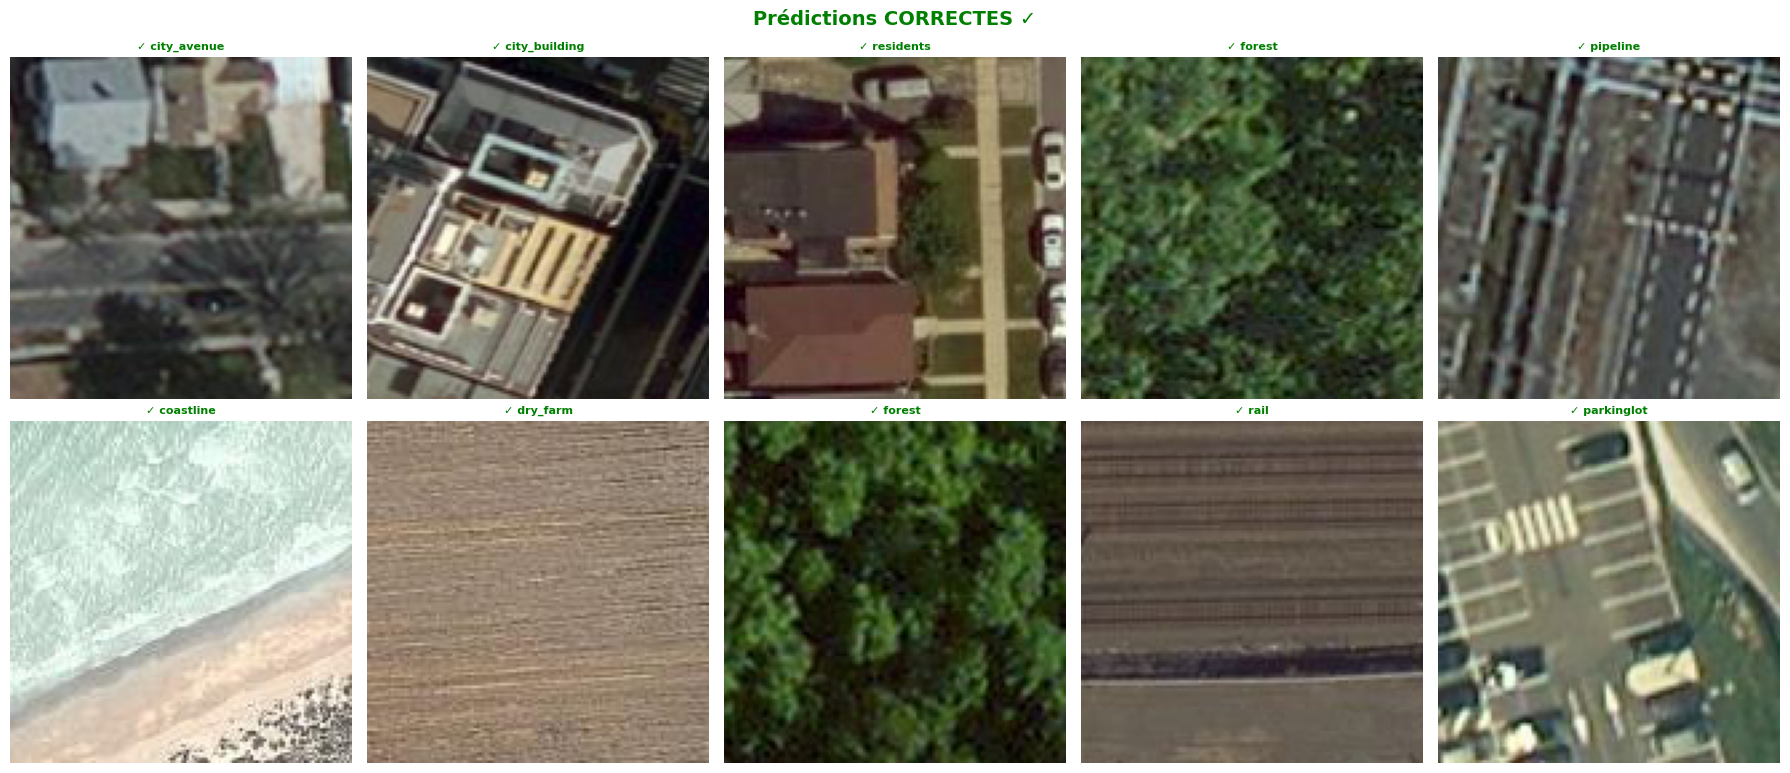

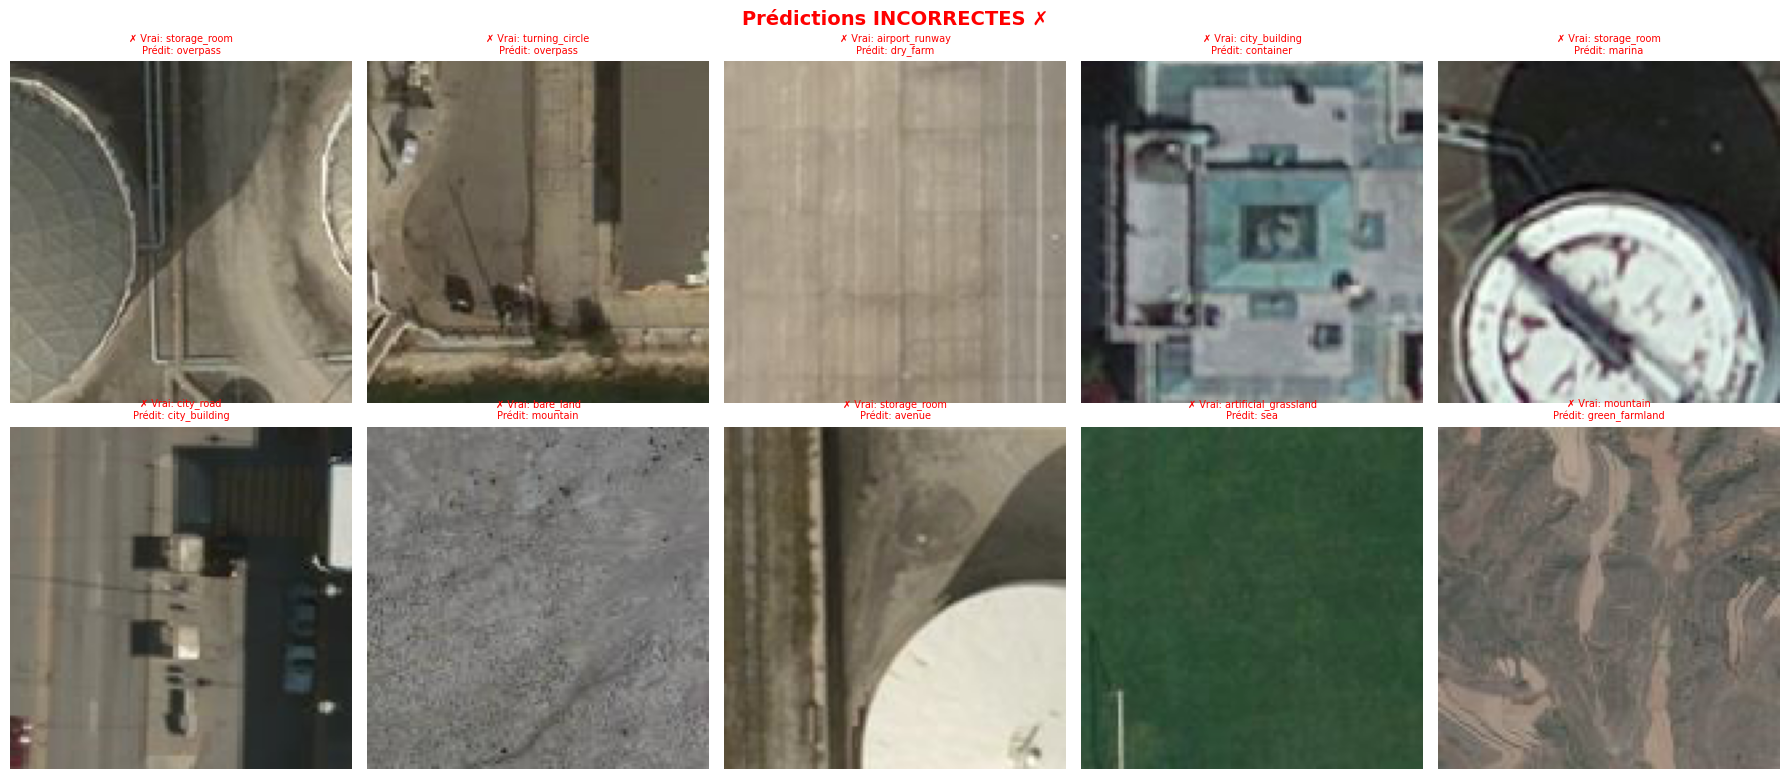

In [26]:
# Afficher des exemples de prédictions correctes et incorrectes
model.eval()
correct_imgs, incorrect_imgs = [], []

with torch.no_grad():
    for images, labels in test_loader:
        outputs   = model(images.to(device))
        _, preds  = torch.max(outputs, 1)
        preds     = preds.cpu()
        for i in range(len(images)):
            item = {'image': images[i], 'true': labels[i].item(), 'pred': preds[i].item()}
            if preds[i] == labels[i] and len(correct_imgs) < 10:
                correct_imgs.append(item)
            elif preds[i] != labels[i] and len(incorrect_imgs) < 10:
                incorrect_imgs.append(item)
        if len(correct_imgs) >= 10 and len(incorrect_imgs) >= 10:
            break

def show_predictions(items, title, color):
    n = len(items)
    fig, axes = plt.subplots(2, 5, figsize=(18, 8))
    axes = axes.ravel()
    for i, item in enumerate(items[:10]):
        img = (item['image'] * 0.5 + 0.5).permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        axes[i].imshow(img)
        true_name = class_names[item['true']]
        pred_name = class_names[item['pred']]
        if item['true'] == item['pred']:
            axes[i].set_title(f"✓ {true_name}", fontsize=8, color='green', fontweight='bold')
        else:
            axes[i].set_title(f"✗ Vrai: {true_name}\nPrédit: {pred_name}", fontsize=7, color='red')
        axes[i].axis('off')
    plt.suptitle(title, fontsize=14, fontweight='bold', color=color)
    plt.tight_layout()
    return fig

fig1 = show_predictions(correct_imgs,   'Prédictions CORRECTES ✓', 'green')
plt.savefig('06_predictions_correctes.png', dpi=150, bbox_inches='tight')
plt.show()

fig2 = show_predictions(incorrect_imgs, 'Prédictions INCORRECTES ✗', 'red')
plt.savefig('07_predictions_incorrectes.png', dpi=150, bbox_inches='tight')
plt.show()


## 🏆 13. Résumé Final

In [ ]:
print("\n" + "="*70)
print("🏆 RÉSUMÉ FINAL DU PROJET CNN RSI-CB128 (PyTorch)")
print("="*70)

print("\n📊 DATASET :")
print(f"  • Classes         : {NUM_CLASSES}")
print(f"  • Total images    : {len(all_image_paths)}")
print(f"  • Train           : {len(train_dataset)} ({len(train_dataset)/len(all_image_paths)*100:.1f}%)")
print(f"  • Validation      : {len(val_dataset)} ({len(val_dataset)/len(all_image_paths)*100:.1f}%)")
print(f"  • Test            : {len(test_dataset)} ({len(test_dataset)/len(all_image_paths)*100:.1f}%)")

print("\n🧠 MODÈLE :")
print(f"  • Architecture    : RSI_CNN (4 blocs Conv + FC)")
print(f"  • Paramètres      : {total_params:,}")
print(f"  • Framework       : PyTorch {torch.__version__}")

print("\n⚙️ ENTRAÎNEMENT :")
print(f"  • Epochs réalisées  : {len(history['loss'])}/{EPOCHS}")
print(f"  • Batch size        : {BATCH_SIZE}")
print(f"  • LR initial        : {LR}")
print(f"  • Optimiseur        : Adam")
print(f"  • Scheduler         : ReduceLROnPlateau (factor=0.5, patience=3)")
print(f"  • Early Stopping    : patience=5")

print("\n🎯 RÉSULTATS :")
print(f"  • Meilleure val acc : {best_val_acc:.2f}%  (epoch {best_epoch})")
print(f"  • Test accuracy     : {test_accuracy:.2f}%")
print(f"  • Test loss         : {test_loss:.4f}")

print("\n📁 FICHIERS GÉNÉRÉS :")
print("  • models/best_model.pth       ← Modèle PyTorch")
print("  • models/model_info.json      ← Infos pour l'app Streamlit")
print("  • model_metadata.json         ← Métadonnées (compatibilité TF app)")
print("  • training_history.pkl        ← Historique entraînement")
print("  • class_names.pkl             ← Noms des classes")
print("  • class_mappings.pkl          ← Mappings idx↔class")
print("  • classification_report.txt   ← Rapport détaillé")




🏆 RÉSUMÉ FINAL DU PROJET CNN RSI-CB128 (PyTorch)

📊 DATASET :
  • Classes         : 45
  • Total images    : 36707
  • Train           : 26428 (72.0%)
  • Validation      : 6608 (18.0%)
  • Test            : 3671 (10.0%)

🧠 MODÈLE :
  • Architecture    : RSI_CNN (4 blocs Conv + FC)
  • Paramètres      : 5,251,373
  • Framework       : PyTorch 2.5.1+cu121

⚙️ ENTRAÎNEMENT :
  • Epochs réalisées  : 20/20
  • Batch size        : 32
  • LR initial        : 0.001
  • Optimiseur        : Adam
  • Scheduler         : ReduceLROnPlateau (factor=0.5, patience=3)
  • Early Stopping    : patience=5

🎯 RÉSULTATS :
  • Meilleure val acc : 93.81%  (epoch 19)
  • Test accuracy     : 93.41%
  • Test loss         : 0.2188

📁 FICHIERS GÉNÉRÉS :
  • models/best_model.pth       ← Modèle PyTorch
  • models/model_info.json      ← Infos pour l'app Streamlit
  • model_metadata.json         ← Métadonnées (compatibilité TF app)
  • training_history.pkl        ← Historique entraînement
  • class_names.pkl       

: 